Import packages and set the directory to load data

In [6]:
# work with jl2815 environment
import xarray as xr # for netCDF4 
import pandas as pd
import numpy as np
from netCDF4 import Dataset
from matplotlib import pyplot as plt
import os
# Ignore warnings due to duplicated dimension names
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="xarray")
from pathlib import Path

import sys
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)

from GEMS_TCO import configuration as config

2024 01: hours: 00 to 05   N3035_E100110
2023 04: hours: 00 to 07   N3035_E100110
2023 01: hours: 00 to 05   N3035_E100110

2023: y23m04day20_8 and y23m07day13_8 missing !! for N3035_E100110
2023: y23m04day20_8 !! for N3035_E110120

2023 04: hours: 00 to 07   N3035_E110120           
2023 07: hours: 00 to 07   N3035_E110120
2024 04: hours: 00 to 07   N3035_E110120
2024 07: hours: 00 to 07   N3035_E110120

# Explore Groups in the NetCDF file

In [56]:
# file_path = "/Volumes/Backup Plus/GEMS_UNZIPPED/2024070131/20240701_0045.nc"  # portable device
file_path = "/Users/joonwonlee/Documents/GEMS_DATA/2024070131/20240701_0045.nc" # mac
location = xr.open_dataset(file_path, group='Geolocation Fields')
Z = xr.open_dataset(file_path, group='Data Fields')


import netCDF4 as nc

dataset = nc.Dataset(file_path)

# Print all group names
print("Groups in the NetCDF file:")
for group_name in dataset.groups:
    print(group_name)

# Optionally, print variables in each group
for group_name, group in dataset.groups.items():
    print(f"\nVariables in group '{group_name}':")
    for var_name in group.variables:
        print(var_name)

# Close the dataset
dataset.close()


Groups in the NetCDF file:
Data Fields
Geolocation Fields
METADATA

Variables in group 'Data Fields':
AveragingKernel
CloudPressure
ColumnAmountO3
DegreesOfFreedomForSignal
EstimatedError
FinalAlgorithmFlags
LayerEfficiency
Nvalue
O3BelowCloud
Reflectivity340
Reflectivity380
Residue
StepOneO3
StepTwoO3
TerrainPressure
dNdR
dR_dl
EffectiveCloudFraction

Variables in group 'Geolocation Fields':
Latitude
Longitude
RelativeAzimuthAngle
SolarZenithAngle
ViewingZenithAngle
Time
GroundPixelQualityFlags

Variables in group 'METADATA':


# Truncate the area of interest

In [117]:
class GemsORITocsvHour:          
    def __init__(self, lat_s,lat_e,lon_s,lon_e):
        self.lat_s = lat_s 
        self.lat_e = lat_e  
        self.lon_s = lon_s
        self.lon_e = lon_e                         
  
    def extract_data(self,file_path):
        location = xr.open_dataset(file_path, group='Geolocation Fields')
        Z = xr.open_dataset(file_path, group='Data Fields')
        
        location_variables = ['Latitude', 'Longitude', 'Time']
        tmp1 = location[location_variables]

        location_df = tmp1.to_dataframe().reset_index() # Convert xarray.Dataset to pandas DataFrame
        location_df = location_df[location_variables]   # remove spatial (2048), image (695) indices

        Z_variables = ['ColumnAmountO3','FinalAlgorithmFlags']
        tmp2 = Z[Z_variables]

        Z_df = tmp2.to_dataframe().reset_index()      
        Z_df = Z_df[Z_variables]

        mydata = pd.concat([location_df, Z_df], axis=1)      # both rows are 2048*695
  
        # Close the NetCDF file
        location.close()
        Z.close()
        return mydata
    
    def dropna(self, file_path):
        mydata = self.extract_data(file_path)
        mydata = mydata.dropna(subset=['Latitude', 'Longitude','Time','ColumnAmountO3','FinalAlgorithmFlags'])
        return mydata

    def ORItocsv(self, file_path):

        df = self.dropna(file_path)  
        truncated_df = df[ (df['Latitude']<= self.lat_e) & (df['Latitude']>= self.lat_s) & (df['Longitude']>= self.lon_s) & (df['Longitude']<= self.lon_e) ]
        
        # Cut off missing values
        truncated_df= truncated_df[truncated_df.iloc[:,3]<1000]    

        truncated_df['Time'] = np.mean(truncated_df.iloc[:,2])

        # Convert 'Time' column to datetime type
        # print(df2['Time'])

        truncated_df['Time'] = pd.to_datetime(truncated_df['Time'], unit='h')
        truncated_df['Time'] = truncated_df['Time'].dt.floor('min')  
        
        return truncated_df

class file_path_list:
    def __init__(self, year:int, month:int, computer_path:str):
        self.year = year
        self.month = month
        self.computer_path = computer_path

    def file_names_july24(self):
        if self.month == 2:
            self.day_str = "0128"  # Handle February specifically
        else:
            self.day_str = "0131" if (self.month in [1, 3, 5, 7, 8, 10, 12]) else "0130"

        last_day_range = int(self.day_str[2:])+1
        base_directory = f'{self.year}{self.month:02d}{self.day_str}/'
        file_prefixes = []
        for i in range(1,last_day_range):
            file_prefixes.append(f'{self.year}{self.month:02d}{i:02d}_')
        
        file_paths_list = [f"{self.computer_path}{base_directory}{prefix}{hour:02d}45.nc" for prefix in file_prefixes for hour in range(0, 8)] # 6 for january 8 for else
        return file_paths_list
    
class MonthAggregatedCSV(GemsORITocsvHour):
    def __init__(self, lat_start, lat_end, lon_start, lon_end):
        super().__init__(lat_start, lat_end, lon_start, lon_end)

    def aggregate_july24tocsv(self, file_paths_list):
        aggregated_data = []
        for i, filepath in enumerate(file_paths_list):
            try:
                # Attempt to transform netCDF file into csv for hourly data
                cur_data = self.ORItocsv(filepath)
                aggregated_data.append(cur_data)

            except FileNotFoundError:
                print(f"Warning: File not found - {filepath}. Skipping this file.")
                continue

        # Concatenate all DataFrames at once (more efficient than repeated concat)
        aggregated_df =  pd.concat(aggregated_data, ignore_index=True) if aggregated_data else pd.DataFrame()
        aggregated_df['Hours_elapsed'] = aggregated_df['Time'].astype('int64') // 10**9/3600
        
        acceptable_flags = [0, 2, 4, 128]
        filtered_df = aggregated_df[aggregated_df['FinalAlgorithmFlags'].isin(acceptable_flags)]

        # frequency_table3= gqdata['FinalAlgorithmFlags'].value_counts()
        # print(frequency_table3)
        return filtered_df
    
    def save(self, GoodqualityData, year,month, computer_path):
        # computer_path = config.mac.data_path
        if month == 2:
            day_str = "0128"  # Handle February specifically
        else:
            day_str = "0131" if (month in [1, 3, 5, 7, 8, 10, 12]) else "0130"

        output_file = f'data_{int(str(year)[2:4])}_{month:02d}_{day_str}_N{str(self.lat_s)+str(self.lat_e)}_E{str(self.lon_s)+str(self.lon_e)}.csv' 
        output_csv_path = Path(computer_path)/output_file
        
        # csv_file_path = os.path.join(r"C:\\Users\\joonw\tco\\data_engineering", tmp_path)
        GoodqualityData.to_csv(output_csv_path, index=False)

Extract the region of interest

In [120]:
computer_path = config.mac_data_load_path  # mac
# portable_disk = "/Volumes/Backup Plus/GEMS_UNZIPPED/" 
year=2024
month = 7
filelist_instance = file_path_list(year, month, computer_path)
# filelist_instance = file_path_list(year, month, portable_disk)
file_paths_list = filelist_instance.file_names_july24() 



# instance= MonthAggregatedCSV(4.99, 10.01, 110.01, 123.01)
instance= MonthAggregatedCSV(0, 5, 123, 133)
GoodQualityData = instance.aggregate_july24tocsv(file_paths_list)

check data quality

In [121]:
GoodQualityData.shape[0]/31/8  
# 5 10 123 133  33856 without filtering 0 only: 10759  fine list: 32063 
# 0 5 123 133 00 only  13520  33092 if 0|2|4|128

33092.709677419356

(array([7772075.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  179751.]),
 array([  0.        ,  12.80000019,  25.60000038,  38.40000153,
         51.20000076,  64.        ,  76.80000305,  89.59999847,
        102.40000153, 115.19999695, 128.        ]),
 <BarContainer object of 10 artists>)

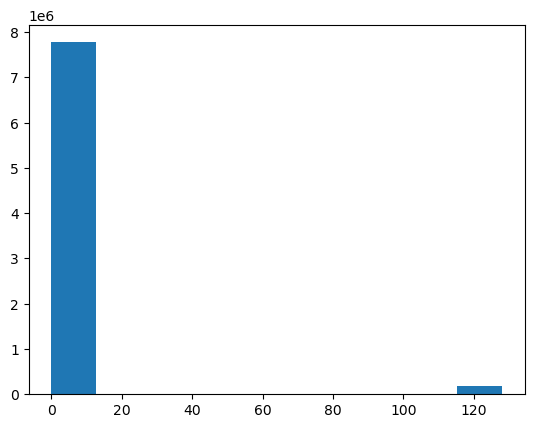

In [114]:
plt.hist( GoodQualityData['FinalAlgorithmFlags'])

save file

In [122]:
instance.save(GoodQualityData, 2024, 7, computer_path)

-observation 1: weird no matter how i truncated why there is consitent missing in some longitude range? (solved: when viewing angle is bad like E110, instrument go downward when moving from East to West)



Make into pickle file

In [45]:
base_path = config.mac_data_load_path   
output_path = base_path

lat_start, lat_end, lon_start, lon_end = 5, 10, 110, 120
# (4.99, 10.01, 110.01, 123.01)
# 4.99, 10.01, 113.49, 123.01

# years = [2023,2024]
years = [2024] 
months = list( range(7,8))
# Loop through months
for year in years:
    for month in months:  
   
        # Construct filenames dynamically
        month_str = f"{month:02d}"  # Ensure month is zero-padded
        if month == 2 and year==2023:
            day_str = "0128"  # Handle February specifically
        elif month ==2 and year==2024:
            day_str = "0129"
        else:
            day_str = "0131" if (month in [1, 3, 5, 7, 8, 10, 12]) else "0130"

        input_filename = f"data_{year}/data_{str(year)[2:]}_{month_str}_{day_str}_N{lat_start}{lat_end}_E{lon_start}{lon_end}.csv"
        
        input_filepath = os.path.join(base_path, input_filename)
        
        # Read data
        print(f"Reading file: {input_filepath}")
        df = pd.read_csv(input_filepath)

df['Orbit'] = df['Time'].str[0:16]

Reading file: /Users/joonwonlee/Documents/GEMS_DATA/data_2024/data_24_07_0131_N510_E110120.csv


old

Create csv file by uing loop for days given month and year

In [ ]:
year = 2024
portable_disk = "/Volumes/Backup Plus/GEMS_UNZIPPED/" 
for month in range(7, 8):  # From January to November
    # filelist_instance = file_path_list(year, month, computer_path)
    filelist_instance = file_path_list(year, month, portable_disk)
    file_paths_list = filelist_instance.file_names_july24() 

    instance= MonthAggregatedCSV(4.9, 10.1, 109.9, 124.1)
    GoodQualityData = instance.aggregate_july24tocsv(file_paths_list)
    instance.save(GoodQualityData, year, month, computer_path)


31
data_23_09_0130_N510_E110120.csv


# You may ignore belows:

# different library 

In [ ]:
import netCDF4 as nc
import pandas as pd

# File path
file_path = "/Users/joonwonlee/Documents/GEMS_DATA/2024070131/20240701_0045.nc"

# Open the NetCDF file
dataset = nc.Dataset(file_path)

# Access specific groups
geolocation_group = dataset.groups['Geolocation Fields']
data_group = dataset.groups['Data Fields']
meta_group = dataset.groups['METADATA']

# Extract variables from the 'Geolocation Fields' group
latitude = geolocation_group.variables['Latitude'][:]
longitude = geolocation_group.variables['Longitude'][:]
time = geolocation_group.variables['Time'][:]

# Ensure time has the same shape as latitude and longitude
if time.shape != latitude.shape:
    time = np.broadcast_to(time, latitude.shape)

# Extract variables from the 'Data Fields' group
column_amount_o3 = data_group.variables['ColumnAmountO3'][:]
final_algorithm_flags = data_group.variables['FinalAlgorithmFlags'][:]

# Create DataFrames
location_df = pd.DataFrame({
    'Latitude': latitude.flatten(),  # Flattening the arrays to 1D
    'Longitude': longitude.flatten(),
    'Time': time.flatten()
})

data_df = pd.DataFrame({
    'ColumnAmountO3': column_amount_o3.flatten(),
    'FinalAlgorithmFlags': final_algorithm_flags.flatten()
})

# Combine DataFrames
mydata = pd.concat([location_df, data_df], axis=1)

# Close the NetCDF file
dataset.close()

# Display the combined DataFrame
print(mydata)